# Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from urllib.parse import quote
from urllib.request import urlopen, Request
from os.path import join
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [2]:
sns.set_context('talk')

# Load data

In [3]:
train = pd.read_pickle('train')

# Prepare data

In [4]:
# Target is whether the virus is detected
y = pd.to_numeric(train.WnvPresent.values)

In [5]:
# Remove unusable features from dataset
X = train.drop(
    ['Date', 'Trap', 'NumMosquitos', 'WnvPresent', 'Species', 'Zone'], axis=1)

In [6]:
# Split data preserving label ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, stratify=y)

In [7]:
# Use borderline SMOTE to fix class imbalance
X_resampled, y_resampled = SMOTE(kind='borderline1').fit_sample(X_train,
                                                                y_train)

# Gradient Boosting Classifier

In [8]:
# Now up the estimators in the random forest, and apply the best parameters
clf = GradientBoostingClassifier(
    n_estimators=1000, learning_rate=0.0035, max_depth=7, random_state=42)
clf.fit(X_resampled, y_resampled)

clf_probs = clf.predict_proba(X_test)
sig_score = log_loss(y_test, clf_probs)

y_pred = clf.predict(X_test)

# Metrics

In [9]:
# Log loss
print(sig_score)

0.246604125872


In [10]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.96      0.93      0.95      2489
          1       0.21      0.33      0.25       138

avg / total       0.92      0.90      0.91      2627



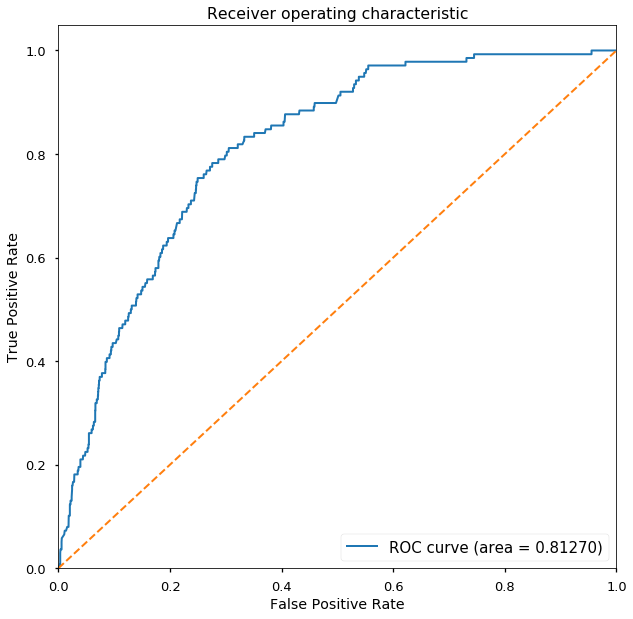

In [11]:
# ROC and AUC
fpr, tpr, _ = roc_curve(y_test, clf_probs[:,1])
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10, 10))
lw = 2
ax.plot(fpr, tpr,
         lw=lw, label='ROC curve (area = %0.5f)' % roc_auc)
ax.plot([0, 1], [0, 1], lw=lw, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right", fontsize=15)
plt.show()
fig.tight_layout()
fig.savefig(join('plots', 'GradBoo', 'ROC.png'))

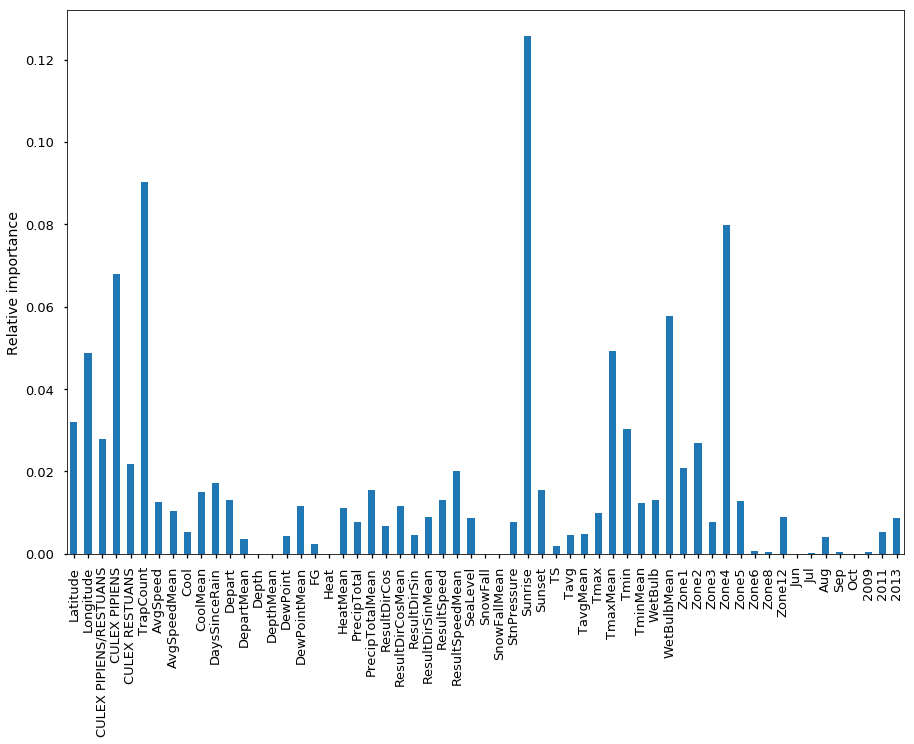

In [12]:
# Plot relative importance of features to model
fig, ax = plt.subplots(figsize=(15,10))
pd.Series(clf.feature_importances_ , index=X.columns).plot(kind='bar', ax=ax)

ax.set_ylabel('Relative importance')

plt.show()
fig.tight_layout()
fig.savefig(join('plots', 'GradBoo', 'importances.png'))